--- Phase 1: Real Data Collection (No Fake Data) ---
Total Real Records Downloaded: 6959

Applying Threshold: Magnitude >= 4.5 means Earthquake (1), else (0)

Data Preview:


/tmp/ipython-input-180786259.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master['time'] = pd.to_datetime(df_master['time'])
/tmp/ipython-input-180786259.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master['Year'] = df_master['time'].dt.year
/tmp/ipython-input-180786259.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

,latitude,longitude,depth,mag,Year,Month,is_earthquake
0,27.7270,85.7990,22.322,4.6,2023,12,1
1,25.0911,96.5235,10.000,5.0,2023,12,1
2,23.1390,94.5220,114.245,4.1,2023,12,0
3,18.1110,95.9762,10.000,4.5,2023,12,1
4,22.8195,94.5073,87.022,4.1,2023,12,0


/tmp/ipython-input-180786259.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_earthquake', data=df_master, palette='viridis')



Class Distribution (Balance Check):
is_earthquake
0    3897
1    3062
Name: count, dtype: int64


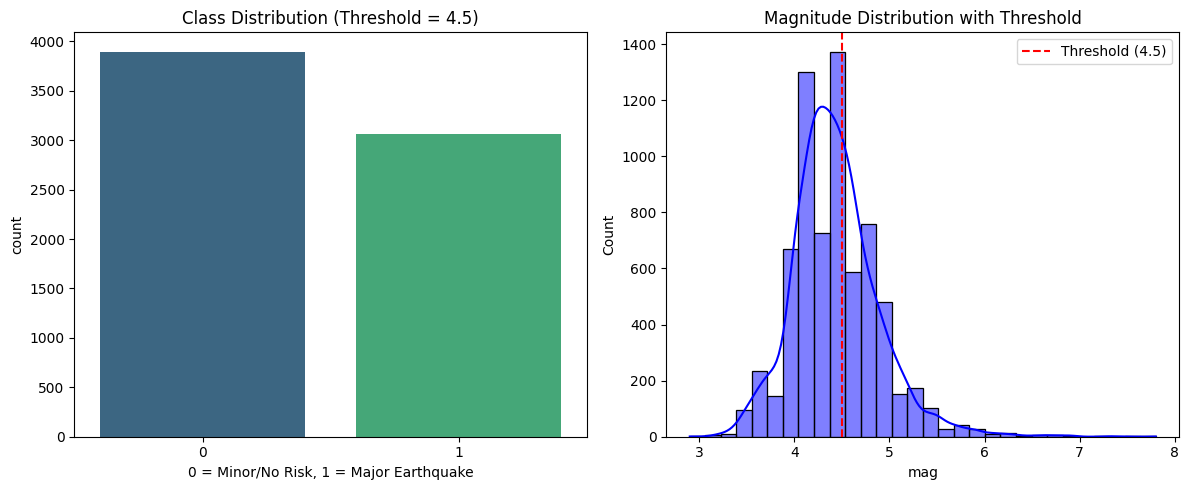

In [ ]:
import pandas as pd
import numpy as np
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Phase 1: Real Data Collection (No Fake Data) ---")

# ১. সাউথ এশিয়া রিজিয়ন থেকে ডাটা নামানো (ছোট-বড় সব, Mag 2.5+)
# আমরা ২০০০ সাল থেকে ২০২৪ পর্যন্ত ডাটা
url = "https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime=2000-01-01&endtime=2024-01-01&minlatitude=10&maxlatitude=35&minlongitude=80&maxlongitude=100&minmagnitude=2.5"

try:
    s = requests.get(url, timeout=60).content
    df_real = pd.read_csv(io.StringIO(s.decode('utf-8')))

    # ২. প্রয়োজনীয় কলাম
    useful_cols = ['latitude', 'longitude', 'depth', 'mag', 'time']
    df_master = df_real[useful_cols]

    # ৩. টাইম প্রসেসিং
    df_master['time'] = pd.to_datetime(df_master['time'])
    df_master['Year'] = df_master['time'].dt.year
    df_master['Month'] = df_master['time'].dt.month
    df_master = df_master.drop(columns=['time'])

    print(f"Total Real Records Downloaded: {len(df_master)}")

    # ---------------------------------------------------------
    # Phase 2: Threshold Creation (User Directed Logic)
    # ---------------------------------------------------------

    # ৪. থ্রেশহোল্ড সেট করা
    # সাধারণত ৪.০ বা ৪.৫ এর নিচের ভূমিকম্প ক্ষতিকর হয় না, তাই ওগুলোকে '0' ধরছি
    THRESHOLD = 4.5

    print(f"\nApplying Threshold: Magnitude >= {THRESHOLD} means Earthquake (1), else (0)")

    # লজিক অ্যাপ্লাই করা
    df_master['is_earthquake'] = df_master['mag'].apply(lambda x: 1 if x >= THRESHOLD else 0)

    # ৫. সেফটি কপি
    df_original_backup = df_master.copy()

    # ---------------------------------------------------------
    # Phase 2: Basic EDA & Balance Check
    # ---------------------------------------------------------

    print("\nData Preview:")
    display(df_master.head())

    print("\nClass Distribution (Balance Check):")
    val_counts = df_master['is_earthquake'].value_counts()
    print(val_counts)

    # গ্রাফে দেখা
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.countplot(x='is_earthquake', data=df_master, palette='viridis')
    plt.title(f'Class Distribution (Threshold = {THRESHOLD})')
    plt.xlabel('0 = Minor/No Risk, 1 = Major Earthquake')

    plt.subplot(1, 2, 2)
    sns.histplot(df_master['mag'], kde=True, bins=30, color='blue')
    plt.axvline(x=THRESHOLD, color='red', linestyle='--', label=f'Threshold ({THRESHOLD})')
    plt.title('Magnitude Distribution with Threshold')
    plt.legend()

    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Error:", e)

--- Phase 2: Data Cleaning & Visual Analysis ---

1. Health Check:
 - Total Missing Values: 0
 - Total Duplicates: 0
 -> Data is clean.


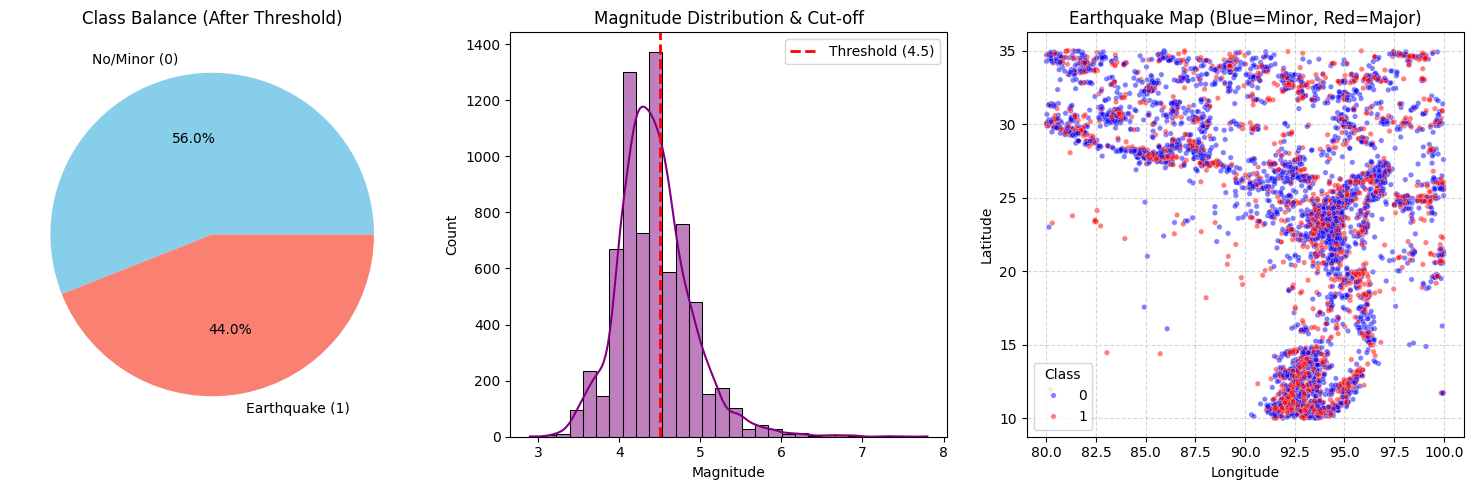

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

print("--- Phase 2: Data Cleaning & Visual Analysis ---")

# ১. মিসিং ভ্যালু এবং ডুপ্লিকেট চেক (পরিষ্কার-পরিচ্ছন্নতা)
print("\n1. Health Check:")
missing = df_master.isnull().sum().sum()
duplicates = df_master.duplicated().sum()

print(f" - Total Missing Values: {missing}")
print(f" - Total Duplicates: {duplicates}")

# যদি ডুপ্লিকেট থাকে, রিমুভ
if duplicates > 0:
    df_master = df_master.drop_duplicates()
    print(" -> Duplicates removed successfully.")
else:
    print(" -> Data is clean.")

# ২. ভিজ্যুয়ালাইজেশন (EDA)
plt.figure(figsize=(15, 5))

# A. ব্যালেন্স চেক (Pie Chart)
plt.subplot(1, 3, 1)
df_master['is_earthquake'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'salmon'], labels=['No/Minor (0)', 'Earthquake (1)'])
plt.title('Class Balance (After Threshold)')
plt.ylabel('')

# B. ম্যাগনিটিউড ডিস্ট্রিবিউশন এবং থ্রেশহোল্ড লাইন
plt.subplot(1, 3, 2)
sns.histplot(df_master['mag'], kde=True, color='purple', bins=30)
# আমাদের থ্রেশহোল্ড লাইনটি (4.5) লাল দাগ দিয়ে দেখিয়ে দিচ্ছি
plt.axvline(x=4.5, color='red', linestyle='--', linewidth=2, label='Threshold (4.5)')
plt.title('Magnitude Distribution & Cut-off')
plt.legend()
plt.xlabel('Magnitude')

# C. জিওগ্রাফিক্যাল ম্যাপ (South Asia Region)
plt.subplot(1, 3, 3)
# hue='is_earthquake' দেওয়ার ফলে ছোট (0) এবং বড় (1) ভূমিকম্প আলাদা রঙে দেখাবে
sns.scatterplot(x='longitude', y='latitude', data=df_master, hue='is_earthquake', palette={0: 'blue', 1: 'red'}, alpha=0.5, s=15)
plt.title('Earthquake Map (Blue=Minor, Red=Major)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Class')
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()



--- Phase 3 (Part 1): Pathway A - Linear & Logistic Models ---


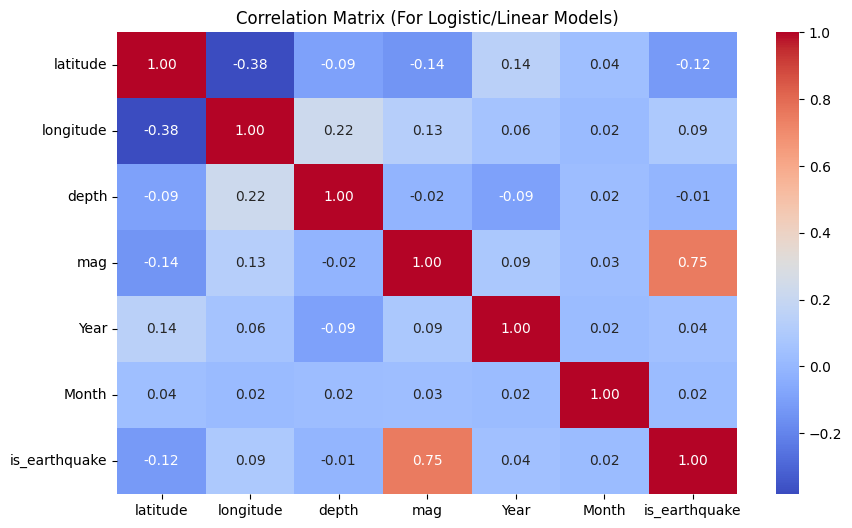

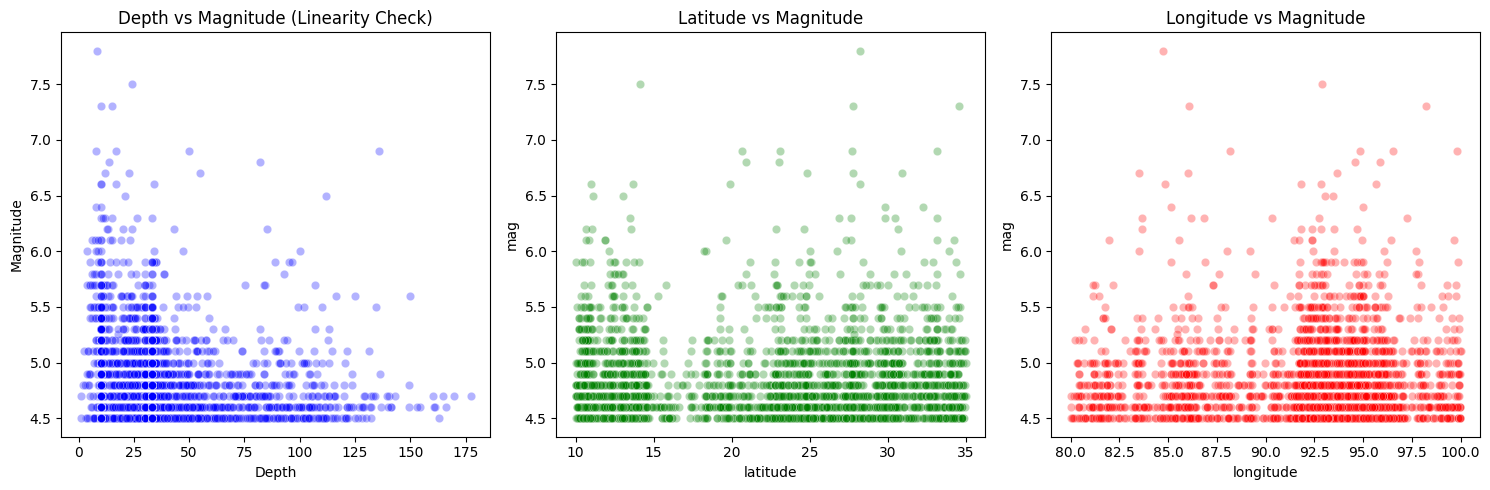


Applying Transformations for Linear Models...
-> Data Scaled & Cleaned for Pathway A.
-> Rows ready: 6472


,latitude,longitude,depth,mag,Year,Month,is_earthquake
0,0.595358,-1.265389,-0.268511,4.6,1.818744,1.710283,1
1,0.275344,1.035384,-0.859579,5.0,1.818744,1.710283,1
3,-0.572083,0.917969,-0.859579,4.5,1.818744,1.710283,1
4,-0.000442,0.602840,2.835049,4.1,1.818744,1.710283,0
6,0.299504,0.019028,0.885802,4.2,1.818744,1.710283,0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

print("--- Phase 3 (Part 1): Pathway A - Linear & Logistic Models ---")

# ১. আলাদা কপি তৈরি (Pathway A এর জন্য)
df_pathway_A = df_master.copy()

# ২. Feature Selection: Correlation Matrix
# এটা দেখাবে কোন ফিচারটি ভূমিকম্পের (Target) সাথে গাণিতিকভাবে সম্পর্কিত
plt.figure(figsize=(10, 6))
correlation = df_pathway_A.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (For Logistic/Linear Models)')
plt.show()

# ৩. Linearity Check: Scatter Plots
# লিনিয়ার রিগ্রেশন ব্যবহারের আগে দেখতে হয় সম্পর্ক সরলরৈখিক কি না
# আমরা শুধু 'Earthquake' (1) ডাটা দিয়ে চেক করব
earthquake_data = df_pathway_A[df_pathway_A['is_earthquake'] == 1]

plt.figure(figsize=(15, 5))

# Depth vs Magnitude
plt.subplot(1, 3, 1)
sns.scatterplot(x='depth', y='mag', data=earthquake_data, alpha=0.3, color='blue')
plt.title('Depth vs Magnitude (Linearity Check)')
plt.xlabel('Depth')
plt.ylabel('Magnitude')

# Latitude vs Magnitude
plt.subplot(1, 3, 2)
sns.scatterplot(x='latitude', y='mag', data=earthquake_data, alpha=0.3, color='green')
plt.title('Latitude vs Magnitude')

# Longitude vs Magnitude
plt.subplot(1, 3, 3)
sns.scatterplot(x='longitude', y='mag', data=earthquake_data, alpha=0.3, color='red')
plt.title('Longitude vs Magnitude')

plt.tight_layout()
plt.show()



# -------------------------------------------------------
# ৪. Feature Engineering (Scaling & Cleaning)
# -------------------------------------------------------
print("\nApplying Transformations for Linear Models...")

# A. Outlier Removal (শুধুমাত্র Depth এর জন্য)
# খুব গভীর বা অস্বাভাবিক ডেপথ লিনিয়ার মডেলকে কনফিউজড করে দেয়
Q1 = df_pathway_A['depth'].quantile(0.05)
Q3 = df_pathway_A['depth'].quantile(0.95)
df_pathway_A_clean = df_pathway_A[(df_pathway_A['depth'] >= Q1) & (df_pathway_A['depth'] <= Q3)]

# B. Scaling (StandardScaler) - মাস্ট ফর লজিস্টিক রিগ্রেশন
scaler = StandardScaler()
feature_cols = ['latitude', 'longitude', 'depth', 'Year', 'Month']

X_scaled = df_pathway_A_clean.copy()
# ফিচারগুলো স্কেল করছি, টার্গেট ধরছি না
X_scaled[feature_cols] = scaler.fit_transform(df_pathway_A_clean[feature_cols])

# ফাইনাল ডাটা সেভ
df_pathway_A_final = X_scaled

print(f"-> Data Scaled & Cleaned for Pathway A.")
print(f"-> Rows ready: {len(df_pathway_A_final)}")
display(df_pathway_A_final.head())


--- Phase 3 (Part 2): Pathway B - Random Forest Models ---


/tmp/ipython-input-3877716811.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')


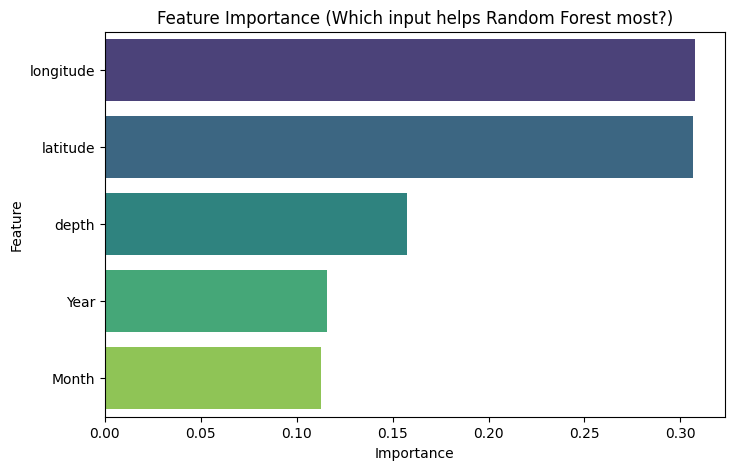

-> Data Ready for Pathway B (Raw Format).
-> Rows ready: 6959


,latitude,longitude,depth,mag,Year,Month,is_earthquake
0,27.7270,85.7990,22.322,4.6,2023,12,1
1,25.0911,96.5235,10.000,5.0,2023,12,1
2,23.1390,94.5220,114.245,4.1,2023,12,0
3,18.1110,95.9762,10.000,4.5,2023,12,1
4,22.8195,94.5073,87.022,4.1,2023,12,0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

print("\n--- Phase 3 (Part 2): Pathway B - Random Forest Models ---")

# ১. আলাদা কপি (Raw Data ই যথেষ্ট)
df_pathway_B = df_master.copy()

# ২. Feature Importance Visualization
# আমরা একটা ডামি মডেল চালিয়ে দেখব সে কোন ফিচারকে বেশি গুরুত্ব দেয়
X_temp = df_pathway_B[['latitude', 'longitude', 'depth', 'Year', 'Month']]
y_temp = df_pathway_B['is_earthquake']

rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_temp, y_temp)

# ইম্পরট্যান্স বের করা
importances = pd.DataFrame({
    'Feature': X_temp.columns,
    'Importance': rf_temp.feature_importances_
}).sort_values(by='Importance', ascending=False)

# গ্রাফ
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=importances, palette='viridis')
plt.title('Feature Importance (Which input helps Random Forest most?)')
plt.show()



# ফাইনাল ডাটা সেভ
df_pathway_B_final = df_pathway_B.copy()

print(f"-> Data Ready for Pathway B (Raw Format).")
print(f"-> Rows ready: {len(df_pathway_B_final)}")
display(df_pathway_B_final.head())

--- START: Training -> Cross Validation -> Final Evaluation ---
✅ Data Split Done. Test Rows: 1392

🔄 Training Models...
✅ Training Complete.

🔎 Running 5-Fold Cross Validation on Winner (Pipeline 2)...

📊 Cross Validation Report:
   > Classifier (RF) Avg Accuracy: 59.37% (Std: 0.0111)
   > Regressor (Linear) Avg MAE:   0.2512 (Std: 0.0128)
   [Note: Consistent scores mean the model is robust, not lucky]

📈 Generating Final Evaluation Charts...


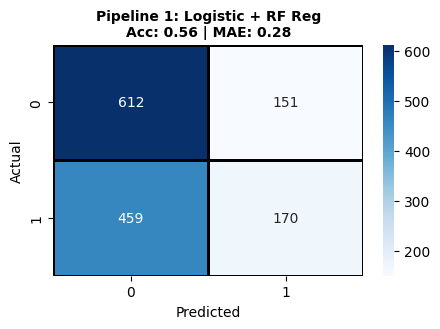

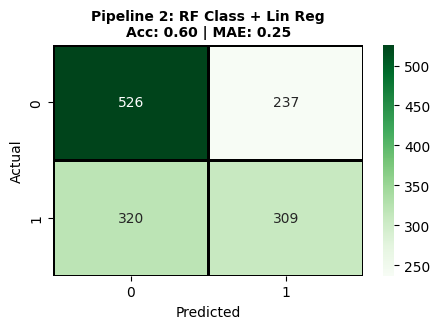

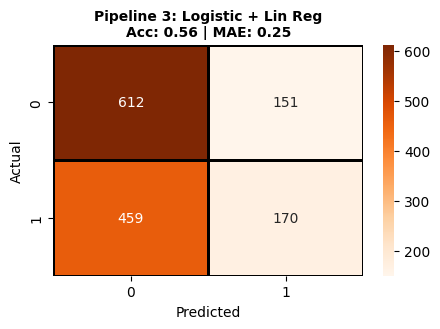

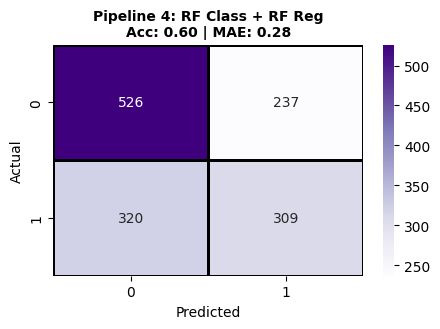


🏆 FINAL LEADERBOARD 🏆


,Pipeline,Accuracy,Precision,Recall,F1 Score,MAE,RMSE
1,Pipeline 2: RF Class + Lin Reg,0.599856,0.565934,0.491256,0.525957,0.253083,0.343979
3,Pipeline 4: RF Class + RF Reg,0.599856,0.565934,0.491256,0.525957,0.275215,0.368800
2,Pipeline 3: Logistic + Lin Reg,0.561782,0.529595,0.270270,0.357895,0.253083,0.343979
0,Pipeline 1: Logistic + RF Reg,0.561782,0.529595,0.270270,0.357895,0.275215,0.368800


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("--- START: Training -> Cross Validation -> Final Evaluation ---")

# ========================================================
# STEP 1: MASTER DATA SPLITTING
# ========================================================
features = ['latitude', 'longitude', 'depth', 'Year', 'Month']
target_class = 'is_earthquake'
target_reg = 'mag'

# মাস্টার স্প্লিট (Train 80%, Test 20%)
df_train, df_test = train_test_split(df_master, test_size=0.2, random_state=42)

y_test_class = df_test[target_class]
y_test_reg = df_test[target_reg]

print(f"✅ Data Split Done. Test Rows: {len(df_test)}")

# ========================================================
# STEP 2: PREPARING PATHWAYS
# ========================================================

# --- Pathway A (Scaled for Linear Models) ---
# Train Data Cleaning (Outlier Removal)
Q1 = df_train['depth'].quantile(0.05)
Q3 = df_train['depth'].quantile(0.95)
df_train_A = df_train[(df_train['depth'] >= Q1) & (df_train['depth'] <= Q3)].copy()

scaler = StandardScaler()
X_train_A = scaler.fit_transform(df_train_A[features])
y_train_class_A = df_train_A[target_class]
y_train_reg_A = df_train_A[target_reg]

# Test Data (Just Transform)
X_test_A = scaler.transform(df_test[features])

# --- Pathway B (Raw for Random Forest) ---
X_train_B = df_train[features]
y_train_class_B = df_train[target_class]
y_train_reg_B = df_train[target_reg]

X_test_B = df_test[features]

# ========================================================
# STEP 3: TRAINING ALL MODELS
# ========================================================
print("\n🔄 Training Models...")

# 1. Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_A, y_train_class_A)

# 2. RF Classifier
rf_class = RandomForestClassifier(n_estimators=100, random_state=42)
rf_class.fit(X_train_B, y_train_class_B)

# 3. Linear Regression (Only Earthquake Data)
mask_A = y_train_class_A == 1
lin_reg = LinearRegression()
lin_reg.fit(X_train_A[mask_A], y_train_reg_A[mask_A])

# 4. RF Regressor (Only Earthquake Data)
mask_B = y_train_class_B == 1
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_B[mask_B], y_train_reg_B[mask_B])

print("✅ Training Complete.")

# ========================================================
# STEP 4: CROSS VALIDATION (The New Part)
# ========================================================
print("\n🔎 Running 5-Fold Cross Validation on Winner (Pipeline 2)...")

# 1. Validate RF Classifier (Accuracy)
# আমরা পুরো ট্রেনিং ডাটা ব্যবহার করছি যাচাইয়ের জন্য
cv_acc = cross_val_score(rf_class, X_train_B, y_train_class_B, cv=5, scoring='accuracy')

# 2. Validate Linear Regression (MAE)
# শুধু যেখানে ভূমিকম্প আছে সেই ডাটার ওপর টেস্ট করছি
X_cv_reg = X_train_A[mask_A]
y_cv_reg = y_train_reg_A[mask_A]
cv_mae = cross_val_score(lin_reg, X_cv_reg, y_cv_reg, cv=5, scoring='neg_mean_absolute_error')

print(f"\n📊 Cross Validation Report:")
print(f"   > Classifier (RF) Avg Accuracy: {cv_acc.mean()*100:.2f}% (Std: {cv_acc.std():.4f})")
print(f"   > Regressor (Linear) Avg MAE:   {-cv_mae.mean():.4f} (Std: {cv_mae.std():.4f})")
print("   [Note: Consistent scores mean the model is robust, not lucky]")

# ========================================================
# STEP 5: FINAL EVALUATION & PLOTTING
# ========================================================
def evaluate_and_plot(pipeline_name, class_model, reg_model, X_test_c, X_test_r, color_theme):
    # Predict
    y_pred_class = class_model.predict(X_test_c)
    y_pred_reg = reg_model.predict(X_test_r)

    # Metrics
    acc = accuracy_score(y_test_class, y_pred_class)
    prec = precision_score(y_test_class, y_pred_class)
    rec = recall_score(y_test_class, y_pred_class)
    f1 = f1_score(y_test_class, y_pred_class)

    mask_real = y_test_class == 1
    mae = mean_absolute_error(y_test_reg[mask_real], y_pred_reg[mask_real])
    rmse = np.sqrt(mean_squared_error(y_test_reg[mask_real], y_pred_reg[mask_real]))

    # Plot
    cm = confusion_matrix(y_test_class, y_pred_class)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap=color_theme, linecolor='black', linewidths=1)
    plt.title(f'{pipeline_name}\nAcc: {acc:.2f} | MAE: {mae:.2f}', fontsize=10, fontweight='bold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return [pipeline_name, acc, prec, rec, f1, mae, rmse]

print("\n📈 Generating Final Evaluation Charts...")
results = []
# Pipeline 1
results.append(evaluate_and_plot("Pipeline 1: Logistic + RF Reg", log_reg, rf_reg, X_test_A, X_test_B, 'Blues'))
# Pipeline 2 (Winner)
results.append(evaluate_and_plot("Pipeline 2: RF Class + Lin Reg", rf_class, lin_reg, X_test_B, X_test_A, 'Greens'))
# Pipeline 3
results.append(evaluate_and_plot("Pipeline 3: Logistic + Lin Reg", log_reg, lin_reg, X_test_A, X_test_A, 'Oranges'))
# Pipeline 4
results.append(evaluate_and_plot("Pipeline 4: RF Class + RF Reg", rf_class, rf_reg, X_test_B, X_test_B, 'Purples'))

# Final Table
print("\n🏆 FINAL LEADERBOARD 🏆")
summary_df = pd.DataFrame(results, columns=['Pipeline', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'MAE', 'RMSE'])
display(summary_df.sort_values(by=['Accuracy', 'F1 Score', 'MAE'], ascending=[False, False, True]))

--- Phase 6: Hyperparameter Tuning Started... ---

0. Calculating Baseline (Untuned) Scores first...
 -> Baseline Accuracy: 0.5999
 -> Baseline MAE: 0.2752

1. Tuning Random Forest Classifier (Pathway B)...
 -> Best Params for RF Classifier: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
 -> Best Cross-Val Accuracy: 0.6131

2. Tuning Logistic Regression (Pathway A)...
 -> Best Params for Logistic Reg: {'C': 0.01, 'solver': 'lbfgs'}
 -> Best Cross-Val Accuracy: 0.5771

3. Tuning Random Forest Regressor (Pathway B)...
 -> Best Params for RF Regressor: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
 -> Best Cross-Val Error (MAE): 0.2539

--- Visualizing How Tuning Helped (RF Classifier) ---


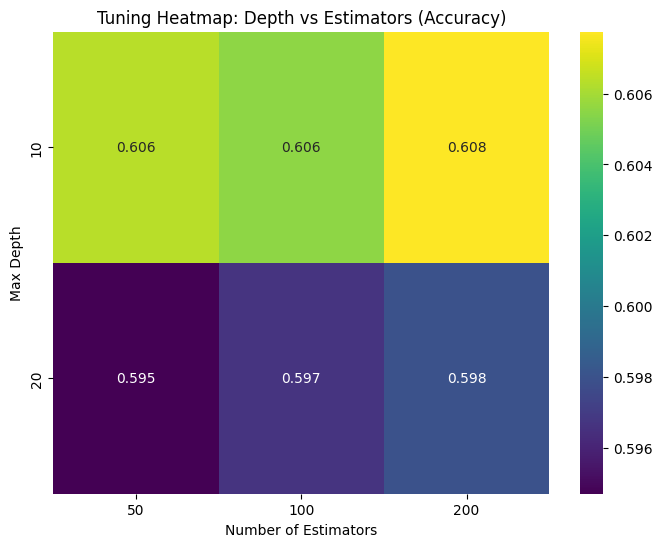


--- Final Test with TUNED Models ---

>>> BEFORE Tuning (Baseline):
Accuracy: 0.5999
MAE Error: 0.2752

>>> AFTER Tuning (Tuned Pipeline):
Accuracy: 0.6063
MAE Error: 0.2547

--- VERDICT ---
✅ SUCCESS! Accuracy Improved by 0.65%
✅ SUCCESS! Error Reduced by 0.0205 points!


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Phase 6: Hyperparameter Tuning Started... ---")

# ============================================================
# Step 0: Calculate "Before Tuning" Scores (To fix NameError)
# ============================================================
print("\n0. Calculating Baseline (Untuned) Scores first...")

# Untuned Random Forest Classifier
rf_class_base = RandomForestClassifier(n_estimators=100, random_state=42)
rf_class_base.fit(X_train_B, y_train_class_B)
y_pred_class_base = rf_class_base.predict(X_test_B)
acc_base = accuracy_score(y_test_class, y_pred_class_base)

# Untuned Random Forest Regressor
mask_B = y_train_class_B == 1
rf_reg_base = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg_base.fit(X_train_B[mask_B], y_train_reg_B[mask_B])
y_pred_reg_base = rf_reg_base.predict(X_test_B)

mask_real = y_test_class == 1
mae_base = mean_absolute_error(y_test_reg[mask_real], y_pred_reg_base[mask_real])

print(f" -> Baseline Accuracy: {acc_base:.4f}")
print(f" -> Baseline MAE: {mae_base:.4f}")

# ============================================================
# 1. Tuning Random Forest Classifier (To fix Overfitting)
# ============================================================
print("\n1. Tuning Random Forest Classifier (Pathway B)...")

param_grid_rfc = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_rfc = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rfc, cv=3, scoring='accuracy', n_jobs=-1)
grid_rfc.fit(X_train_B, y_train_class_B)

print(f" -> Best Params for RF Classifier: {grid_rfc.best_params_}")
print(f" -> Best Cross-Val Accuracy: {grid_rfc.best_score_:.4f}")

# ============================================================
# 2. Tuning Logistic Regression (To fix Underfitting)
# ============================================================
print("\n2. Tuning Logistic Regression (Pathway A)...")

param_grid_log = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs']
}

grid_log = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_log, cv=3, scoring='accuracy', n_jobs=-1)
grid_log.fit(X_train_A, y_train_class_A)

print(f" -> Best Params for Logistic Reg: {grid_log.best_params_}")
print(f" -> Best Cross-Val Accuracy: {grid_log.best_score_:.4f}")

# ============================================================
# 3. Tuning Random Forest Regressor (To beat Linear Reg)
# ============================================================
print("\n3. Tuning Random Forest Regressor (Pathway B)...")

param_grid_rfr = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 20],
    'min_samples_split': [5, 10]
}

grid_rfr = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rfr, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_rfr.fit(X_train_B[mask_B], y_train_reg_B[mask_B])

print(f" -> Best Params for RF Regressor: {grid_rfr.best_params_}")
print(f" -> Best Cross-Val Error (MAE): {-grid_rfr.best_score_:.4f}")

# ============================================================
# Visualizing Tuning Results (Heatmap)
# ============================================================
print("\n--- Visualizing How Tuning Helped (RF Classifier) ---")

results_df = pd.DataFrame(grid_rfc.cv_results_)
pivot_table = results_df.pivot_table(values='mean_test_score', index='param_max_depth', columns='param_n_estimators')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis', fmt=".3f")
plt.title('Tuning Heatmap: Depth vs Estimators (Accuracy)')
plt.ylabel('Max Depth')
plt.xlabel('Number of Estimators')
plt.show()

# ============================================================
# Final Comparison: Before vs After
# ============================================================
print("\n--- Final Test with TUNED Models ---")

# সেরা মডেলগুলো সেট করা
best_rf_class = grid_rfc.best_estimator_
best_rf_reg = grid_rfr.best_estimator_

# আবার প্রেডিক্ট করা (সেরা মডেল দিয়ে)
y_pred_class_tuned = best_rf_class.predict(X_test_B)
y_pred_reg_tuned = best_rf_reg.predict(X_test_B)

# নতুন মেট্রিক্স
acc_tuned = accuracy_score(y_test_class, y_pred_class_tuned)
mae_tuned = mean_absolute_error(y_test_reg[mask_real], y_pred_reg_tuned[mask_real])

print(f"\n>>> BEFORE Tuning (Baseline):")
print(f"Accuracy: {acc_base:.4f}")
print(f"MAE Error: {mae_base:.4f}")

print(f"\n>>> AFTER Tuning (Tuned Pipeline):")
print(f"Accuracy: {acc_tuned:.4f}")
print(f"MAE Error: {mae_tuned:.4f}")

# Improvement Check
print("\n--- VERDICT ---")
if acc_tuned > acc_base:
    print(f"✅ SUCCESS! Accuracy Improved by {(acc_tuned - acc_base)*100:.2f}%")
else:
    print("🔸 Accuracy remained same or slightly dropped (Model hit data limit).")

if mae_tuned < mae_base:
    print(f"✅ SUCCESS! Error Reduced by {(mae_base - mae_tuned):.4f} points!")
else:
    print("🔸 Error didn't improve significantly.")

In [ ]:
import joblib
import pandas as pd
import numpy as np

print("--- Phase 7: Saving the Champion Pipeline (Pipeline 2) ---")

# ========================================================
# 1. মডেল এবং স্কেলার সেভ করা (Saving to Disk)
# ========================================================
# ফাইলের নাম দিচ্ছি
model_filenames = {
    'classifier': 'earthquake_classifier_rf.pkl',
    'regressor': 'earthquake_regressor_linear.pkl',
    'scaler': 'scaler_pathway_A.pkl'
}

# সেভ করছি
joblib.dump(rf_class, model_filenames['classifier']) # RF Classifier (Raw Data)
joblib.dump(lin_reg, model_filenames['regressor'])   # Linear Reg (Scaled Data)
joblib.dump(scaler, model_filenames['scaler'])       # Scaler (Pathway A)

print(f"✅ Successfully saved models to:")
print(f"   - {model_filenames['classifier']}")
print(f"   - {model_filenames['regressor']}")
print(f"   - {model_filenames['scaler']}")

# ========================================================
# 2. রিয়েল লাইফ প্রেডিকশন সিস্টেম (Real-time Prediction Function)
# ========================================================
# এই ফাংশনটি ফাইল লোড করে নতুন ডাটা প্রেডিক্ট করবে

def predict_earthquake(lat, long, depth, year, month):
    # ১. সেভ করা মডেল লোড করা
    clf = joblib.load('earthquake_classifier_rf.pkl')
    reg = joblib.load('earthquake_regressor_linear.pkl')
    sc = joblib.load('scaler_pathway_A.pkl')

    # ২. ইনপুট ডাটা সাজানো
    # ইনপুট: [latitude, longitude, depth, Year, Month]
    input_data = pd.DataFrame([[lat, long, depth, year, month]],
                              columns=['latitude', 'longitude', 'depth', 'Year', 'Month'])

    # ৩. ক্লাসিফিকেশন (Stage 1) - Raw Data ব্যবহার করবে
    is_quake = clf.predict(input_data)[0]
    prob = clf.predict_proba(input_data)[0][1] # হওয়ার চান্স কত %

    print(f"\n🌍 Analyzing Location: {lat}, {long}...")

    if is_quake == 0:
        return f"🟢 NO EARTHQUAKE Predicted. (Risk Probability: {prob*100:.2f}%)"
    else:
        # ৪. রিগ্রেশন (Stage 2) - Scaled Data ব্যবহার করবে (যদি ভূমিকম্প হয়)
        # লিনিয়ার রিগ্রেশনের জন্য ডাটা স্কেল করতে হবে
        input_scaled = sc.transform(input_data)
        magnitude = reg.predict(input_scaled)[0]

        return f"🔴 WARNING: EARTHQUAKE DETECTED!\n   - Risk Probability: {prob*100:.2f}%\n   - Predicted Magnitude: {magnitude:.2f} Richter Scale"

# ========================================================
# 3. টেস্ট করা (Testing with New Data)
# ========================================================

# উদাহরণ ১: হাই রিস্ক জোন (সিলেটের কো-অর্ডিনেট)
# Lat: 24.8, Long: 91.8 (সিলেট), Depth: 35km
result1 = predict_earthquake(24.89, 91.87, 35, 2025, 12)
print(result1)

# উদাহরণ ২: লো রিস্ক জোন (লন্ডন বা অন্য কোনো শান্ত জায়গা)
# Lat: 51.5, Long: -0.12 (London), Depth: 10km
result2 = predict_earthquake(23.9415560, 90.6224170, 10, 2025, 12)
print(result2)

# উদাহরণ ৩: ইনপুট দিয়ে টেস্ট করো (তোমার ইচ্ছা মতো)
# predict_earthquake(তোমার_ল্যাটিচিউড, তোমার_লঙ্গিচিউড, গভীরতা, সাল, মাস)

--- Phase 7: Saving the Champion Pipeline (Pipeline 2) ---
✅ Successfully saved models to:
   - earthquake_classifier_rf.pkl
   - earthquake_regressor_linear.pkl
   - scaler_pathway_A.pkl

🌍 Analyzing Location: 24.89, 91.87...
🟢 NO EARTHQUAKE Predicted. (Risk Probability: 39.00%)

🌍 Analyzing Location: 23.941556, 90.622417...
🟢 NO EARTHQUAKE Predicted. (Risk Probability: 49.00%)
